# 新規材料の予測
5.predict_all.ipynbのNN ver

In [44]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

import optuna

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pickle
import joblib

from scipy.spatial.distance import cdist

from rdkit import Chem
from rdkit.Chem import Draw

## データ読み込み＆前処理

In [45]:
# 入力：読み込みたい記述子のタイプを選択
descriptor_type = 'mordred_3d'  # 'rdkit' or 'mordred_2d' or 'mordred_3d'

# ベースのデータ
dataset = pd.read_csv('data/material_data.csv', index_col=0)

# 条件に応じて記述子ファイルを読み込む
if descriptor_type == "rdkit":
    des = pd.read_csv("outputs/descriptors/descriptor_rdkit.csv", index_col=0)
elif descriptor_type == "mordred_2d":
    des = pd.read_csv("outputs/descriptors/descriptor_mordred_2d.csv", index_col=0)
elif descriptor_type == "mordred_3d":
    des = pd.read_csv("outputs/descriptors/descriptor_mordred_3d.csv", index_col=0)
else:
    raise ValueError(f"未知のdescriptor_type: {descriptor_type}")

# 結合
dataset_full = pd.concat([dataset.reset_index(), des.reset_index(drop=True)], axis=1)
dataset_full = dataset_full.set_index('Material')

# 確認
print(dataset.shape, des.shape, dataset_full.shape)

(1258, 3) (1258, 1479) (1258, 1482)


In [46]:
# TypeとSMILESも消す
dataset_full = dataset_full.drop(['SMILES', 'Type'], axis=1)

# 学習用と予測用に分ける
dataset_train = dataset_full.dropna(subset=['PL']).copy()
dataset_test = dataset_full[dataset_full['PL'].isnull()].copy()

# 予測データのPLは空なので消す
dataset_test = dataset_test.drop('PL', axis=1)

# 1. 両方のデータセットでinfをNaNに置き換える
dataset_train.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2. 学習データに基づいて削除すべき列を特定する
#    - NaNを含む列
nan_cols = dataset_train.columns[dataset_train.isnull().any()]
#    - 標準偏差が0の列
zero_std_cols = dataset_train.columns[dataset_train.std() == 0]

#    - 削除する列の全リスト (重複をなくす)
cols_to_drop = nan_cols.union(zero_std_cols)
print(f"学習データに基づいて削除する列の数: {len(cols_to_drop)}")


# 3. 特定した同じ列を「両方のデータセット」から削除する
dataset_train.drop(columns=cols_to_drop, inplace=True)
dataset_test.drop(columns=cols_to_drop, inplace=True, errors='ignore') # テストデータにその列がなくてもエラーにしない

# 4. テストデータに残っているNaNを「学習データの平均値」で埋める
#    まず、学習データから各列の平均値を計算します。
imputation_values = dataset_train.drop('PL', axis=1).mean()

#    計算した平均値を使ってテストデータの欠損値を埋めます。
dataset_test.fillna(imputation_values, inplace=True)

print("\n処理後のshape:")
print(dataset_train.shape, dataset_test.shape)

# 列数が一致していることを確認
if dataset_train.shape[1] - 1 == dataset_test.shape[1]:
    print("✅ 列数が一致しました！ (学習データ: 目的変数分+1)")
else:
    print("❌ 列数が一致していません。")

学習データに基づいて削除する列の数: 260

処理後のshape:
(251, 1220) (1007, 1219)
✅ 列数が一致しました！ (学習データ: 目的変数分+1)


In [47]:
# 最終的な特徴量共通セット
X_train_all = dataset_train.drop(columns='PL')
y_train_all = dataset_train['PL']
X_test = dataset_test.copy()  # PLなし

## NNモデルの作成

In [48]:
# GPU set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'使用デバイス：{device}')

使用デバイス：cuda


In [49]:
# パラメータなど読み込み
best_trial = joblib.load('models/nn/hparams.pkl')
feature_names = joblib.load('models/nn/feature_names.pkl')
# スケーラー読み込み
X_scaler = joblib.load('models/nn/X_scaler.pkl')
y_scaler = joblib.load('models/nn/y_scaler.pkl')

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define_modelを再定義（Optunaの設定と一致）
def define_model(trial, input_dim):
    layers = []
    n_layers = trial['n_layers']
    hidden_dim = trial['hidden_dim']
    dropout_rate = trial['dropout_rate']
    activation_name = trial['activation']
    use_batchnorm = trial['use_batchnorm']

    in_dim = input_dim
    for i in range(n_layers):
        layers.append(nn.Linear(in_dim, hidden_dim))

        if use_batchnorm:
            layers.append(nn.BatchNorm1d(hidden_dim))

        if activation_name == "relu":
            layers.append(nn.ReLU())
        else:
            layers.append(nn.LeakyReLU())

        layers.append(nn.Dropout(dropout_rate))
        in_dim = hidden_dim

    layers.append(nn.Linear(in_dim, 1))
    return nn.Sequential(*layers)

In [50]:
# 列順合わせ、標準化
X_test = X_test[feature_names]                
autoscaled_X_test = X_scaler.transform(X_test)

# テンソル変換
X_test_tensor = torch.tensor(autoscaled_X_test, dtype=torch.float32).to(device)

# モデル構築（trial情報を渡す）
model = define_model(best_trial, input_dim=len(feature_names)).to(device)

# パラメータ読み込み
state = torch.load('models/nn/final_model.pth', map_location=device)
model.load_state_dict(state)
model.eval()

Sequential(
  (0): Linear(in_features=1219, out_features=524, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.011821131613319363, inplace=False)
  (3): Linear(in_features=524, out_features=524, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.011821131613319363, inplace=False)
  (6): Linear(in_features=524, out_features=524, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.011821131613319363, inplace=False)
  (9): Linear(in_features=524, out_features=1, bias=True)
)

In [51]:
# 推論
with torch.no_grad():
    y_test_pred_scaled = model(X_test_tensor).cpu().numpy()

# 逆スケーリング
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
y_test_pred = pd.DataFrame(y_test_pred, columns=['pred_PL'], index=dataset_test.index)

# 予測結果を表示
print(y_test_pred)

             pred_PL
Material            
test1     558.755798
test2     697.464661
test3     644.675476
test4     619.315613
test5     565.570496
...              ...
test1003  482.010223
test1004  514.723389
test1005  604.059509
test1006  539.133606
test1007  556.219543

[1007 rows x 1 columns]


In [52]:
# 結果の保存、モデル名を使って保存

# 出力用ディレクトリを作成
os.makedirs("outputs/predictions", exist_ok=True)

output_path = f'outputs/predictions/predict_y_nn.csv'
y_test_pred.to_csv(output_path)

print(f"予測結果を {output_path} に保存しました")

予測結果を outputs/predictions/predict_y_nn.csv に保存しました


## ADモデル

### OCSVM

In [53]:
def gamma_optimization_with_variance(x, gammas):
    """
    DataFrame型もしくはarray型のxにおいて、カーネル関数におけるグラム行列の分散を最大化することにより、yを最適化する関数

    Parameters
    -----------------------------------
    x : pandas.DataFrame or numpy.array
    gammas : list

    Returns
    -------
    optimized gamma : scaler

    """

    print('カーネル関数においてグラム行列の分散を最大化することによりγの最適化')

    variance_of_gamma_matrix = []

    for index, ocsvm_gamma in enumerate(gammas):
        # print(index + 1, '/', len(gammas))
        gram_matrix = np.exp(-ocsvm_gamma * cdist(x, x, metric='sqeuclidean'))
        variance_of_gamma_matrix.append(gram_matrix.var(ddof=1))

    return gammas[variance_of_gamma_matrix.index(max(variance_of_gamma_matrix))]

In [54]:
# OCSVMによるAD
# OCSVMにおけるnu, nu=0.317(σ), nu=0.045(2σ), nu=0.003(3σ)など選択でき、学習時の境界の形・きつさを決めるハイパラ
# 学習データのうち、最大でnuだけを境界の外にしても良いという上限を与える（サポートベクタ比の下限）
# nuの値が大きくなるとADは狭まるが誤差は小さくなり、nuが小さくなるとADは広がるが、誤差は大きくなる
# nu=0.317ならば、約68%のデータが含まれる範囲（±1σ相当）を定義するイメージ、ただし直感的なイメージであって、厳密な対応ではない。
ocsvm_nu = 0.003

# γの候補
ocsvm_gammas = 2 ** np.arange(-20, 11, dtype=float)

# 学習データの標準化
autoscaled_X_train = X_scaler.transform(X_train_all)

# グラム行列の分散を最大化することによるγの候補、最も情報量の多いγを選ぶことができる
optimal_ocsvm_gamma = gamma_optimization_with_variance(autoscaled_X_train, ocsvm_gammas)

print('最適化されたgamma(OCSVM) :', optimal_ocsvm_gamma)

カーネル関数においてグラム行列の分散を最大化することによりγの最適化


最適化されたgamma(OCSVM) : 0.00048828125


In [55]:
# 確認したい ν のリスト（±1σ, ±2σ, ±3σ に対応させた目安）
nu_list = [0.317, 0.045, 0.003]

# 既に求めた gamma を使う（なければ適当な値でOK）
print(f"使用する gamma: {optimal_ocsvm_gamma}")

def coverage(arr_scores):
    """decision_function>=0 を AD 内とみなした割合"""
    return np.mean(arr_scores >= 0)

for nu in nu_list:
    ocsvm = OneClassSVM(kernel='rbf', gamma=optimal_ocsvm_gamma, nu=nu)
    ocsvm.fit(autoscaled_X_train)

    # 学習データのカバー率
    train_scores = ocsvm.decision_function(autoscaled_X_train)
    train_cover = coverage(train_scores)

    # テストデータのカバー率（あれば）
    test_cover = None
    if 'autoscaled_X_test' in globals():
        test_scores = ocsvm.decision_function(autoscaled_X_test)
        test_cover = coverage(test_scores)

    # 理論値（正規分布前提なら 1 - nu のはず）
    theo = 1.0 - nu

    print(f"\nnu={nu:.3f} のとき（理論: {theo:.3%}）")
    print(f"  学習データの実測カバー率: {train_cover:.3%}  （サンプル数: {autoscaled_X_train.shape[0]}）")
    if test_cover is not None:
        print(f"  テストデータの実測カバー率: {test_cover:.3%}  （サンプル数: {autoscaled_X_test.shape[0]}）")


使用する gamma: 0.00048828125

nu=0.317 のとき（理論: 68.300%）
  学習データの実測カバー率: 68.526%  （サンプル数: 251）
  テストデータの実測カバー率: 74.479%  （サンプル数: 1007）

nu=0.045 のとき（理論: 95.500%）
  学習データの実測カバー率: 92.829%  （サンプル数: 251）
  テストデータの実測カバー率: 89.672%  （サンプル数: 1007）

nu=0.003 のとき（理論: 99.700%）
  学習データの実測カバー率: 93.227%  （サンプル数: 251）
  テストデータの実測カバー率: 89.672%  （サンプル数: 1007）


In [56]:
# ADモデル構築
ocsvm_model = OneClassSVM(kernel='rbf', gamma=optimal_ocsvm_gamma, nu=ocsvm_nu)
ocsvm_model.fit(autoscaled_X_train)

# 学習データにおけるデータ密度を算出
data_density_train = ocsvm_model.decision_function(autoscaled_X_train)
# 下位25% をAD外にするように後付けでキャリブレーションする
threshold = np.percentile(data_density_train, 25)

# 予測データに対してADの内外を判定、学習データの分布（＝高密度領域）を学習する
# データ密度の値
data_density_test = ocsvm_model.decision_function(autoscaled_X_test)
in_ad_ocsvm = data_density_test >= threshold

# データ密度が閾値よりも大きい条件のみ抽出
y_test_pos_ocsvm = y_test_pred.iloc[in_ad_ocsvm, :].copy()

print(f"OCSVM-AD しきい値: {threshold:.6f}")
print(f"OCSVM-AD 内サンプル数: {in_ad_ocsvm.sum()} / {len(in_ad_ocsvm)}")

OCSVM-AD しきい値: 0.014955
OCSVM-AD 内サンプル数: 746 / 1007


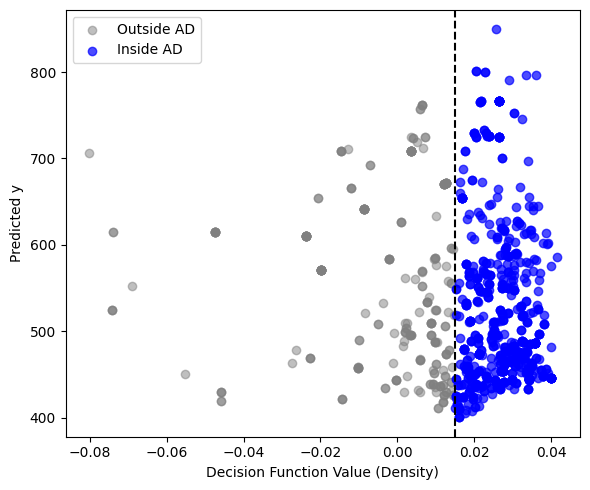

In [57]:
# density ≥ threshold のインデックス
in_ad_index = data_density_test >= threshold
out_ad_index = data_density_test < threshold

# プロット
plt.figure(figsize=(6, 5))
plt.scatter(data_density_test[out_ad_index], y_test_pred.iloc[out_ad_index, 0], 
            color='gray', alpha=0.5, label='Outside AD')
plt.scatter(data_density_test[in_ad_index], y_test_pred.iloc[in_ad_index, 0], 
            color='blue', alpha=0.7, label='Inside AD')
plt.axvline(x=threshold, color='black', linestyle='--')  # しきい値の線
plt.xlabel('Decision Function Value (Density)')
plt.ylabel('Predicted y')
plt.legend()
plt.tight_layout()
plt.show()

### k近傍AD

In [58]:
# kNNモデル作成
k = 5  # 近傍の数（調整可能）
knn_model = NearestNeighbors(metric='euclidean')
knn_model.fit(autoscaled_X_train)

# 学習データの自分を除いた平均近傍距離
dist_train, _ = knn_model.kneighbors(autoscaled_X_train, n_neighbors=k+1)
dist_train_no_self = dist_train[:, 1:]
mean_dist_train = dist_train_no_self.mean(axis=1)

# 距離が大きい25%をAD外とする
threshold = np.percentile(mean_dist_train, 75)

# テストデータの平均近傍距離(相手は学習集合なので、自己は存在しない)
dist_test, _ = knn_model.kneighbors(autoscaled_X_test, n_neighbors=k)
mean_dist_test = dist_test.mean(axis=1)

# 判定(TrueがAD内)
in_ad_knn = mean_dist_test <= threshold

# 予測結果のフィルタ
y_test_pos_knn = y_test_pred[in_ad_knn].copy()

print(f"kNN-AD しきい値: {threshold:.6f}")
print(f"kNN-AD 内サンプル数: {in_ad_knn.sum()} / {len(in_ad_knn)}")

kNN-AD しきい値: 25.134234
kNN-AD 内サンプル数: 779 / 1007


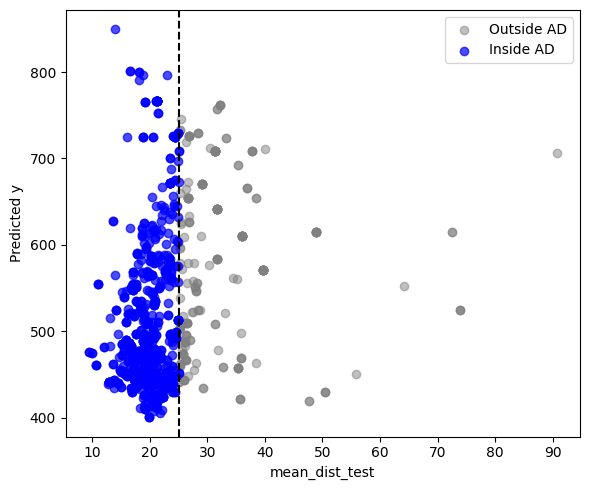

In [59]:
# mean_dist_testがAD閾値より大きいか小さいかでインデックスを分ける
in_ad_index = mean_dist_test <= threshold
out_ad_index = mean_dist_test > threshold

# プロット
plt.figure(figsize=(6, 5))
plt.scatter(mean_dist_test[out_ad_index], y_test_pred.iloc[out_ad_index, 0], 
            color='gray', alpha=0.5, label='Outside AD')
plt.scatter(mean_dist_test[in_ad_index], y_test_pred.iloc[in_ad_index, 0], 
            color='blue', alpha=0.7, label='Inside AD')
plt.axvline(x=threshold, color='black', linestyle='--')  # しきい値（0）の線
plt.xlabel('mean_dist_test')
plt.ylabel('Predicted y')
plt.legend()
plt.tight_layout()
plt.show()

### IsolationForest

In [60]:
# IsolationForestの学習
iso_model = IsolationForest(contamination='auto', random_state=1234)
iso_model.fit(autoscaled_X_train)

# 学習スコア（大きいほど正常/AD内）
train_scores = iso_model.decision_function(autoscaled_X_train)

# 下位25% をAD外にするように後付けでキャリブレーションする
threshold = np.percentile(train_scores, 25)

# テストのAD判定
test_scores = iso_model.decision_function(autoscaled_X_test)
in_ad_iso = test_scores >= threshold

# 予測結果をフィルタ
y_test_pos_iso = y_test_pred[in_ad_iso].copy()

print(f"iso-AD しきい値: {threshold:.6f}")
print(f"iso-AD 内サンプル数: {in_ad_iso.sum()} / {len(in_ad_iso)}")

iso-AD しきい値: 0.060393
iso-AD 内サンプル数: 836 / 1007


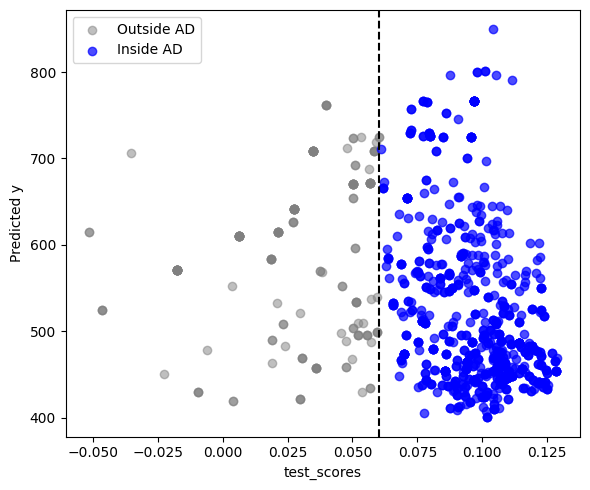

In [61]:
# test_scoresがAD閾値より大きいか小さいかでインデックスを分ける
in_ad_index = test_scores >= threshold
out_ad_index = test_scores < threshold

# プロット
plt.figure(figsize=(6, 5))
plt.scatter(test_scores[out_ad_index], y_test_pred.iloc[out_ad_index, 0], 
            color='gray', alpha=0.5, label='Outside AD')
plt.scatter(test_scores[in_ad_index], y_test_pred.iloc[in_ad_index, 0], 
            color='blue', alpha=0.7, label='Inside AD')
plt.axvline(x=threshold, color='black', linestyle='--')  # しきい値（0）の線
plt.xlabel('test_scores')
plt.ylabel('Predicted y')
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
# 各判定をAND条件で結合
in_all_ads = in_ad_ocsvm & in_ad_knn & in_ad_iso  # True: 全てでAD内

# 最終ADに通す
y_test_final = y_test_pred[in_all_ads].copy()

print(f"3モデルすべてでAD内と判定されたテストサンプル数: {len(y_test_final)}")

3モデルすべてでAD内と判定されたテストサンプル数: 701


In [63]:
# 結果の保存、モデル名を使って保存

ad_output_path = f'outputs/predictions/predict_y_nn_AD3.csv'
y_test_pred.to_csv(ad_output_path)

print(f"ADフィルタ後の予測結果を {ad_output_path} に保存しました")

ADフィルタ後の予測結果を outputs/predictions/predict_y_nn_AD3.csv に保存しました


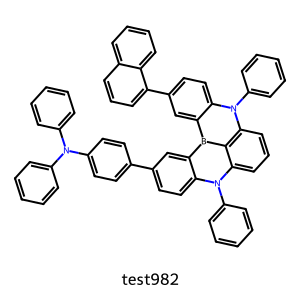

pred_PL    489.281891
Name: test982, dtype: float32


In [64]:
# SMILESを含むCSVまたはExcelファイルを読み込む（例: test.csv）
df = pd.read_csv('data/material_data.csv', index_col=0)
df_test = df[df['PL'].isnull()].copy()

# 見たい番号（テスト集合中の位置）, 0~1006の数字を入力
number = 981

# インデックス名で特定
idx = df_test.index[number]
smiles = df_test.loc[idx, 'SMILES']
mol = Chem.MolFromSmiles(smiles)

# 可視化
img = Draw.MolToImage(mol, size=(300, 300), legend=str(idx))
img.show()

# 予測をインデックス名で参照（AD外なら KeyError を避ける）
if idx in y_test_final.index:
    print(y_test_final.loc[idx])
else:
    print(f'{idx} は AD外（y_test_final に存在しない）です')